In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt
from community import best_partition,modularity
import itertools
from joblib import Parallel, delayed
import pickle
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
import pickle

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [18]:
mat = {}

genre_group = pickle.load(open('genre_group.p', 'rb'))
all_genres = set()

def isNaN(x):
    return x != x

for i,row in df.iterrows():
    if isNaN(row['Combined_Genre']) or row['Score'] < 75:
        continue
    genrelist = row['Combined_Genre'].split('|')
    user = row['User']
    if user not in mat:
        mat[user] = []
    for genre in genrelist:
        if genre in genre_group and genre_group[genre] != 'Non-metal' and genre_group[genre] != 'Others':
            mat[user].append(genre)
            all_genres.add(genre)

for user in mat:
    mat[user] = clt.Counter(mat[user])

mp = {genre:np.zeros(len(mat), dtype = float) for genre in all_genres}

for i,user in enumerate(mat):
    total = sum(mat[user].values())
    for genre in mat[user]:
        mp[genre][i] = mat[user][genre]/total

X = []

for i in range(len(mat)):
    arr = []
    for genre in mp:
        arr.append(mp[genre][i])
    X.append(arr)

X = np.array(X)

X.shape

(8055, 188)

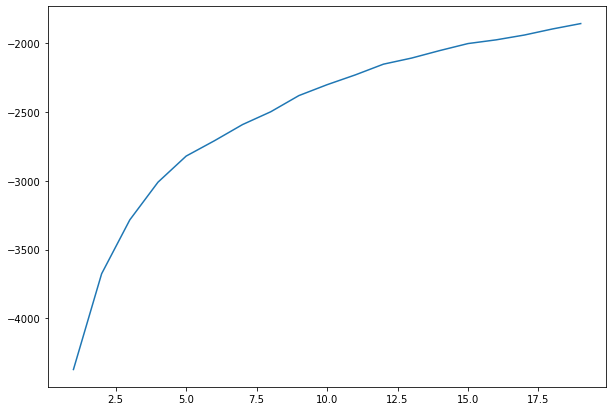

In [53]:
def km(sz):
    kmeans = KMeans(n_clusters=sz, random_state=0).fit(X)
    return kmeans.score(X)

maxi = 20

plt.plot([i for i in range(1,maxi)],[km(i) for i in range(1,maxi)])
plt.show()

In [68]:
kmeans = KMeans(n_clusters=5, random_state=1).fit(X)
labels = list(kmeans.labels_)

kmeans_ids = {user:labels[i] for i,user in enumerate(mat)}

In [69]:
pickle.dump(kmeans_ids, open('kmeans_ids','wb'))

In [71]:
cluster_ids = pickle.load(open('cluster_ids.p','rb'))

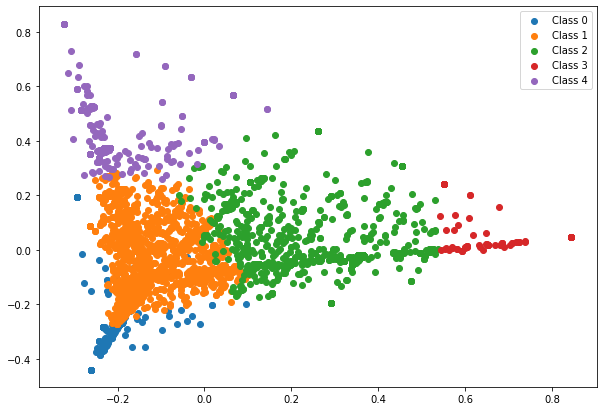

In [70]:
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X))

transformed['labels'] = labels

y = transformed['labels']

for i in range(5):
    plt.scatter(transformed[y==i][0], transformed[y==i][1], label='Class '+ str(i) )


plt.legend()
plt.show()

In [78]:
transformed

,0,1,labels
0,-0.128577,-0.096438,1
1,-0.127056,-0.103668,1
2,-0.191830,-0.269168,0
3,-0.132388,-0.111526,1
4,-0.115699,-0.086005,1
...,...,...,...
8050,-0.138721,-0.082657,1
8051,-0.216044,-0.313785,0
8052,-0.112570,-0.082126,1
8053,-0.323447,0.829894,4


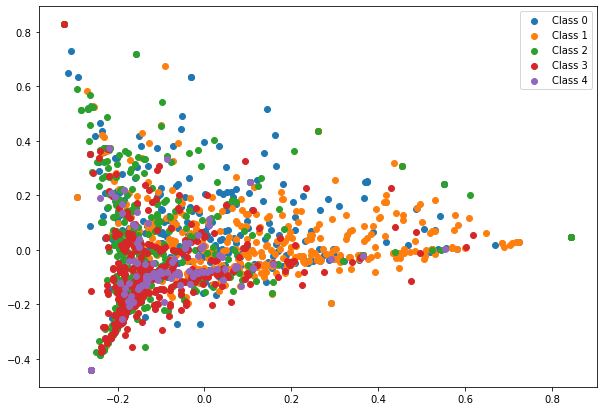

In [91]:
transformed1 = pd.DataFrame()

users = list(mat)

one = []
zero = []

for i,row in transformed.iterrows():
    if users[i] in cluster_ids:
        zero.append(row[0])
        one.append(row[1])

comm_labels = [cluster_ids[user] for user in users if user in cluster_ids]

transformed1[0] = zero
transformed1[1] = one
    
transformed1['comm_labels'] = comm_labels

y1 = transformed1['comm_labels']

for i in range(5):
    plt.scatter(transformed1[y1==i][0], transformed1[y1==i][1], label='Class '+ str(i))
    
plt.legend()
plt.show()